In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
quandl.ApiConfig.api_key = "K42xtcTyEM7To-P_MwmN"
import torch.nn as nn
import torch
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Globals

INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [2]:
# Importing the training set
dataset_train = quandl.get("WIKI/TWTR")
training_set = dataset_train.iloc[:, 0:1].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [12]:
dataset_train[-365:]

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-10-12,18.19,18.1900,17.8100,18.05,23507927.0,0.0,1.0,18.19,18.1900,17.8100,18.05,23507927.0
2016-10-13,17.86,17.9900,17.6700,17.79,18688297.0,0.0,1.0,17.86,17.9900,17.6700,17.79,18688297.0
2016-10-14,17.88,18.0500,16.2800,16.88,73596764.0,0.0,1.0,17.88,18.0500,16.2800,16.88,73596764.0
2016-10-17,16.76,16.9793,16.4300,16.73,25800559.0,0.0,1.0,16.76,16.9793,16.4300,16.73,25800559.0
2016-10-18,16.86,17.1300,16.7900,16.83,18479753.0,0.0,1.0,16.86,17.1300,16.7900,16.83,18479753.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,32.19,33.1500,32.0500,32.73,43359002.0,0.0,1.0,32.19,33.1500,32.0500,32.73,43359002.0
2018-03-22,31.77,32.1300,31.1750,31.20,29284239.0,0.0,1.0,31.77,32.1300,31.1750,31.20,29284239.0
2018-03-23,31.26,32.0000,30.7907,31.03,24478532.0,0.0,1.0,31.26,32.0000,30.7907,31.03,24478532.0


In [3]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, len(training_set)):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) #1-10, 2-11, 3-12

In [6]:
len(training_set)

1102

In [4]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [5]:
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn = rnn.to(DEVICE)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None



In [6]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.16026583313941956
epoch 1, loss 0.12644295394420624
epoch 2, loss 0.09415831416845322
epoch 3, loss 0.0635109692811966
epoch 4, loss 0.036076851189136505
epoch 5, loss 0.015413368120789528
epoch 6, loss 0.007465421687811613
epoch 7, loss 0.016425613313913345
epoch 8, loss 0.02725904807448387
epoch 9, loss 0.02774159237742424
epoch 10, loss 0.02150225080549717
epoch 11, loss 0.014302168972790241
epoch 12, loss 0.009384475648403168
epoch 13, loss 0.0074473656713962555
epoch 14, loss 0.007771363016217947
epoch 15, loss 0.009243175387382507
epoch 16, loss 0.010916681960225105
epoch 17, loss 0.012193030677735806
epoch 18, loss 0.012798143550753593
epoch 19, loss 0.012693570926785469
epoch 20, loss 0.011989928781986237
epoch 21, loss 0.010882068425416946
epoch 22, loss 0.009602434933185577
epoch 23, loss 0.008383716456592083
epoch 24, loss 0.007423949893563986
epoch 25, loss 0.006852120626717806
epoch 26, loss 0.00669924495741725
epoch 27, loss 0.006886654999107122
epoch 28, 

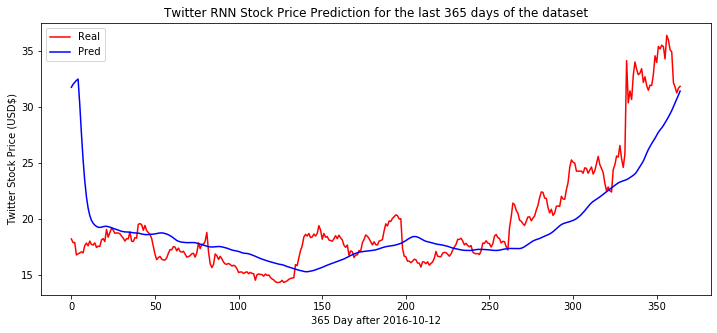

In [16]:
# Getting the real stock price of 2017
real_stock_price = dataset_train.iloc[:, 1:2][-365:].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_train['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_stock_price) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(INPUT_SIZE, 420):
    X_test.append(inputs[i-INPUT_SIZE:i, 0])  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float())
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

# Visualising the results
plt.figure(1, figsize=(12, 5 ))
plt.plot(training_set[-365:], color = 'red', label = 'Real')
plt.plot(predicted_stock_price[-365:], color = 'blue', label = 'Pred')
plt.title('Twitter RNN Stock Price Prediction for the last 365 days of the dataset')
plt.xlabel('365 Day after 2016-10-12')
plt.ylabel('Twitter Stock Price (USD$)')
plt.legend()
plt.show()

In [19]:
# Model score
score = round(r2_score(training_set[-365:], predicted_stock_price[-365:])*100, 4)
accuracy= str(score)
print('Training accuracy: ' + accuracy + '%')

Training accuracy: 54.0381%


In [20]:
#Model MSE
MSE = round(mean_absolute_error(predicted_stock_price[-365:], training_set[-365:]), 4)
MSE = str(MSE)
print('MSE: ' + MSE )

MSE: 2.287
